In [1]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
import cv2
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_dir = '/content/drive/MyDrive/dataset/penyakit kopi/train'
validation_dir = '/content/drive/MyDrive/dataset/penyakit kopi/validation'

In [6]:
def load_images_from_directory(directory, width, height):
    image_data = []
    image_target = []
    classes = os.listdir(directory)
    for title in classes:
        class_dir = os.path.join(directory, title)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    if img.shape[-1] == 1:
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (width, height))
                    image_data.append(img)
                    image_target.append(title)
    return np.array(image_data), np.array(image_target)


In [7]:
train_images, train_labels = load_images_from_directory(train_dir, 224, 224)
validation_images, validation_labels = load_images_from_directory(validation_dir, 224, 224)

train_images = train_images.astype('float32') / 255.0
validation_images = validation_images.astype('float32') / 255.0

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
validation_labels = lb.transform(validation_labels)

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()

model.add(base_model)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(lb.classes_), activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_images, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3049 - loss: 1.6680 - val_accuracy: 0.6125 - val_loss: 1.0317
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5623 - loss: 1.0870 - val_accuracy: 0.7400 - val_loss: 0.8235
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6873 - loss: 0.7961 - val_accuracy: 0.7975 - val_loss: 0.6850
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.7193 - loss: 0.6920 - val_accuracy: 0.8400 - val_loss: 0.5874
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7774 - loss: 0.6389 - val_accuracy: 0.8650 - val_loss: 0.5239
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8117 - loss: 0.5322 - val_accuracy: 0.8700 - val_loss: 0.4755
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8237 - loss: 0.4794 - val_accuracy: 0.8775 - val_loss: 0.4408
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8333 - loss: 0.4697 - val_accuracy: 0.8850 - val_loss:

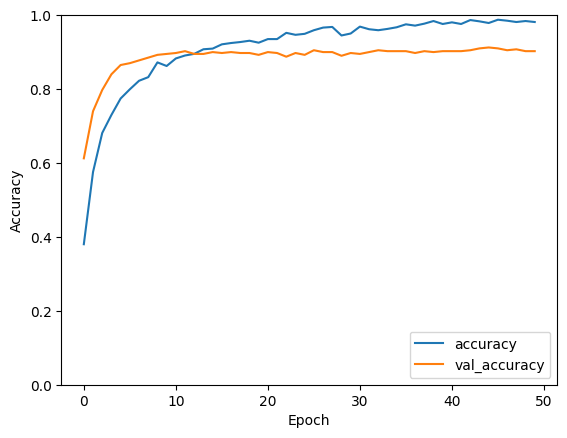

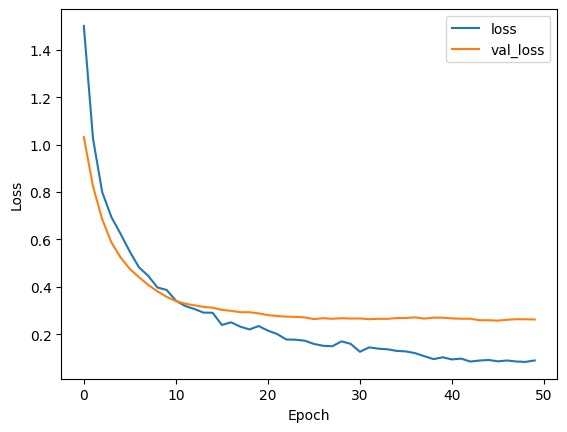

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [11]:
print(os.listdir(train_dir))
print(os.listdir(validation_dir))

['phoma', 'nodisease', 'miner', 'rust']
['miner', 'rust', 'nodisease', 'phoma']


In [12]:
import numpy as np
from keras.preprocessing import image

img_path = '/content/download.jpg'

img = image.load_img(img_path, target_size=(224, 224, 3))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

labels = ['miner', 'nodisease', 'phoma','rust']

prediction = model.predict(img_array)

index = np.argmax(prediction)
class_names = labels[index]


accuracy = np.max(prediction) * 100

predicted_class = class_names
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Accuracy: {accuracy:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: miner
Prediction Accuracy: 97.72%


In [13]:
model.save("/content/coffeLeaf.h5")